# Synthetic baboo residuals

This notebook is used for geberating synthetic pulsar timing residuals for NANOGrav pulsars.

It is based on work from L.Dunn and A.Vargas.

It uses the env `synthetic_baboo_residuals` along with the local copy of `baboo` to which edits have been made

# Setup

Imports and all function definitions

In [1]:

from baboo.baboo.simulation import SimulationModel
import numpy as np

from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt 
import scienceplots

# import baboo

from baboo.baboo.utils import write_tim_file, write_par
import libstempo



In [2]:
#Define all functions

def get_F2(F0,F1,n):
    return (n*F1**2)/F0





def get_PSR_values_from_par(par):
    with open(par) as f:
        for line in f.readlines():
            line = line.strip()
            if line.split(' ')[0] == 'RAJ':
                RAJ=str(line.split()[1])
            if line.split(' ')[0] == 'DECJ':
                DECJ=str(line.split()[1])
            if line.split(' ')[0] == 'F0':
                F0=float(line.split()[1])
            if line.split(' ')[0] == 'F1':
                F1=float(line.split()[1].replace('D','E'))            
            if line.split(' ')[0] == 'START':
                t_START=float(line.split()[1])
            if line.split(' ')[0] == 'FINISH':
                t_FINISH=float(line.split()[1])
            if line.split(' ')[0] == 'NTOA':
                NTOA=int(line.split()[1])
    return 1.0,1.0,F0,F1,t_START,t_FINISH,NTOA #RAJ and DEC are dummy vars




def get_F0_F1_F2_TempoNest(par):
    with open(par) as f:
        for line in f.readlines():
            line = line.strip()
            if line.split(' ')[0] == 'F2':
                F2=float(line.split()[1])
                F2_errs=float(line.split()[-1])
            if line.split(' ')[0] == 'F1':
                F1=float(line.split()[1])
            if line.split(' ')[0] == 'F0':
                F0=float(line.split()[1])
            if line.split(' ')[0] == 'TNRedAmp':
                RedAmp=float(line.split()[-1])
            if line.split(' ')[0] == 'TNRedGam':
                RedSlope=float(line.split()[-1])
    return F0,F1,F2,RedAmp,RedSlope




def create_files_get_psr(toas,toas_errors,pn,F0,F1,F2,RAJ,DECJ,psrj_nNoise_F2,out_prefix_nNoise_F2):
    ####
    write_tim_file(f'{out_prefix_nNoise_F2}',
                   toas, toas_errors, 
                   pn, observatory='BAT')
    write_par(f'{out_prefix_nNoise_F2}',
               F0, F1, toas[0], psrj=psrj_nNoise_F2, F2=F2,
               fit_F2=True, raj=RAJ, decj=DECJ, fit_pos=True)
    ###
    par_nN=f'{out_prefix_nNoise_F2}.par'
    tim_nN=f'{out_prefix_nNoise_F2}.tim'
    ####
    psr_TG=libstempo.tempopulsar(parfile=par_nN,
                                        timfile=tim_nN)
    return psr_TG





def get_REAL_psr(PSR,noNoise_params):
    psrj_F2=f"TimingDataRelease_UTMOST_PSR/{PSR}/{PSR}"
    if noNoise_params==True:
        par_file=f"{psrj_F2}_noAred_beta.par"
    else:
        par_file=f"{psrj_F2}.par"
    tim_file=f"{psrj_F2}.tim"
    psr_inst=libstempo.tempopulsar(parfile=par_file, timfile=tim_file)
    return psr_inst







def get_coords_rad_RA_DEC(RA,DEC):
    Coords=SkyCoord(RA,DEC, unit=(u.hourangle, u.deg),frame='icrs')
    return Coords.ra.rad, Coords.dec.rad



class EM_guided_mean_reverting_PTA_ModelSim(SimulationModel):
    """
    d(phi)/dt = F
    dF/dt = -gamma_F * F + gamma_F * Fbar(t) + xi(t)

    this gets translated in to F and N below
    We have put white noise in dF/dt and white noise amplitudes sigma_F.
    """

    nstates = 2
    def __init__(self, n, gamma_F, sigma_F, Fbar, F1bar, skipsize=1000):
        super(EM_guided_mean_reverting_PTA_ModelSim, self).__init__()
        self.gamma_F = gamma_F
        self.sigma_F = sigma_F
        self.Fbar = Fbar
        self.F1bar=F1bar
        self.n=n
        self.tau=-1*Fbar/((n-1)*F1bar)
        self.skipsize=skipsize
        # set up matrices
        # states are [phase, frequency]
        # also written as [phi, F]
        self.F = np.longdouble(np.array([[0., 1.],
                                         [0., -self.gamma_F]]))
        self.Q = np.longdouble(np.diag([0., np.sqrt(self.sigma_F)]))

    def expectation(self, x, t):
        ## Aux functions
        def Omega(Omega0,n,tau,t):
            frac=t/tau
            fac1=(1+frac)**(1/(1-n))
            return Omega0*fac1 
        def dOmega(dOmega0,n,tau,t):
            frac=t/tau
            fac1=(1+frac)**(n/(1-n))
            return dOmega0*fac1
        ## Secular evolution
        def N_step(t):
            return np.longdouble(np.array([0.,self.gamma_F*Omega(self.Fbar,self.n, self.tau,t)+
                                           dOmega(self.F1bar,self.n,self.tau,t)]))
        
        N_at_t=N_step(t)
        return self.F @ x + N_at_t

    def variance(self, x, t):
        return self.Q

In [3]:
data_path = 'data/'

def pulsar_pipeline(psr_name,error_on_toa,sigma_2):
    
    print(f"Running the residuals pipeline for {psr_name}")
    
    #Get some parameter values
    RAJ,DECJ,F0,F1,t_START,t_FINISH,NTOA=get_PSR_values_from_par(f"{data_path}par/{psr_name}_NANOGrav_12yv4.wb.gls.par")

    
    #Observation times
    Tobs=(t_FINISH-t_START)
    Tobs_s=Tobs*24*60*60

    #RA/DEC in radians
    RA_rad,DEC_rad=get_coords_rad_RA_DEC(RAJ,DECJ)


    #Get the second frequency derivative, assuming $n=3$
    F2=get_F2(F0,F1,3)


    #Define n and gamma - hardcoded
    n_pl = 3
    gamma_F = 1e-13
    
    
    #Now generate a solution    
    p0_YP=[0.,F0]
    print("Generating a phase solution with F0 =", F0)
    toa_errors_YP = (error_on_toa) * np.ones(NTOA)


    times_YP = int(np.floor(t_START)) + np.sort(np.random.choice(np.arange(int(np.floor(t_FINISH-t_START))*100)/100.,
                                                                     size=NTOA, replace=False)).astype(float)
    PSR_instantiation= EM_guided_mean_reverting_PTA_ModelSim(n_pl,gamma_F, sigma_2, F0, F1)
        # generate and fit frequencies
    toas_MOD, toa_errors_MOD, states_with_Noise_MOD, pn_with_MOD =\
        PSR_instantiation.integrate_and_return_pn(times_YP, 
                                                  F0, F1, times_YP[0], p0=p0_YP,
                                                  toa_errors=toa_errors_YP, 
                                                  Ntoas_per_fit=3, nphase_states=1)
    
    
    
    #Plot the phase 
    print(f"Plotting the phase solution for pulsar {psr_name}")    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,8), sharex=True)
    plt.rc('text', usetex=True)
    axes.scatter(toas_MOD,states_with_Noise_MOD + [-F1*x - 0.5*F2*x**2 for x in (toas_MOD - toas_MOD[0])*86400])
    axes.set_ylabel(r"$\nu$", fontsize=25)
    axes.set_xlabel(r"${\rm TOAs}$", fontsize=25)
    plt.suptitle(r"${\rm Phase~variables~as~a~function~of~ToAs~(With~Noise)}$", fontsize=35)
    plt.tight_layout()
    plt.show()


    
    #Get the real residuals
    print("Getting the real residuals")
    PSR_REAL = libstempo.tempopulsar(parfile=f"{data_path}par/{psr_name}_NANOGrav_12yv4.wb.gls.par", timfile=f"{data_path}tim/{psr_name}_NANOGrav_12yv4.wb.tim")
    
    
    #Create some fake residuals
    print("Generating fake residuals")
    out_prefix=f"{data_path}fake_residuals/{psr_name}"
    FAKE_PSR=create_files_get_psr(toas_MOD, toa_errors_MOD,
                                   pn_with_MOD,F0,F1,F2,
                                       RAJ,DECJ,psr_name,out_prefix)
    
    
    
    
    #Plot it all
    print("Generating final plot")
    plt.style.use(['science','std-colors'])
    
    
    
    
    k = np.argsort(PSR_REAL.toas())
    i = np.argsort(FAKE_PSR.toas())
    ###
    PSR_REAL.fit()
    FAKE_PSR.fit()
    num1=psr_name.split('J')[-1].split('-')[0]
    num2=psr_name.split('J')[-1].split('-')[-1]
    #######################################################################
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,6), sharey=True)
    axes[0].errorbar(PSR_REAL.toas()[k],
                     PSR_REAL.residuals()[k],
                         yerr=1e-6*PSR_REAL.toaerrs[k],fmt='.',alpha=0.5 , label=r"${\rm REAL~}$"+r"${\rm J}$"\
                     +rf"${num1}-{num2}$")
    axes[1].errorbar(FAKE_PSR.toas()[i],
                         FAKE_PSR.residuals()[i],
                         yerr=1e-6*FAKE_PSR.toaerrs[i],fmt='.',alpha=0.5, label=r"${\rm FAKE}$")
    axes[0].set_ylabel(r'${\rm Residuals~(s)}$', fontsize=24)
    axes[0].set_xlabel(r'${\rm TOAs}$', fontsize=24);
    axes[1].set_xlabel(r'${\rm TOAs}$', fontsize=24);
    axes[0].set_title(r'${\rm REAL}$', fontsize=24);
    axes[0].text(0.9, 0.90, r'$({\rm i})$', transform=axes[0].transAxes, fontsize=24)
    axes[1].set_title(r'${\rm FAKE}$', fontsize=24);
    axes[1].text(0.9, 0.90, r'$({\rm ii})$', transform=axes[1].transAxes, fontsize=24)
    plt.tight_layout()
    plt.show()
    
    


Running the residuals pipeline for B1937+21
Generating a phase solution with F0 = 641.9282322943168


100%|██████████| 524/524 [04:16<00:00,  2.04it/s]


Plotting the phase solution for pulsar B1937+21


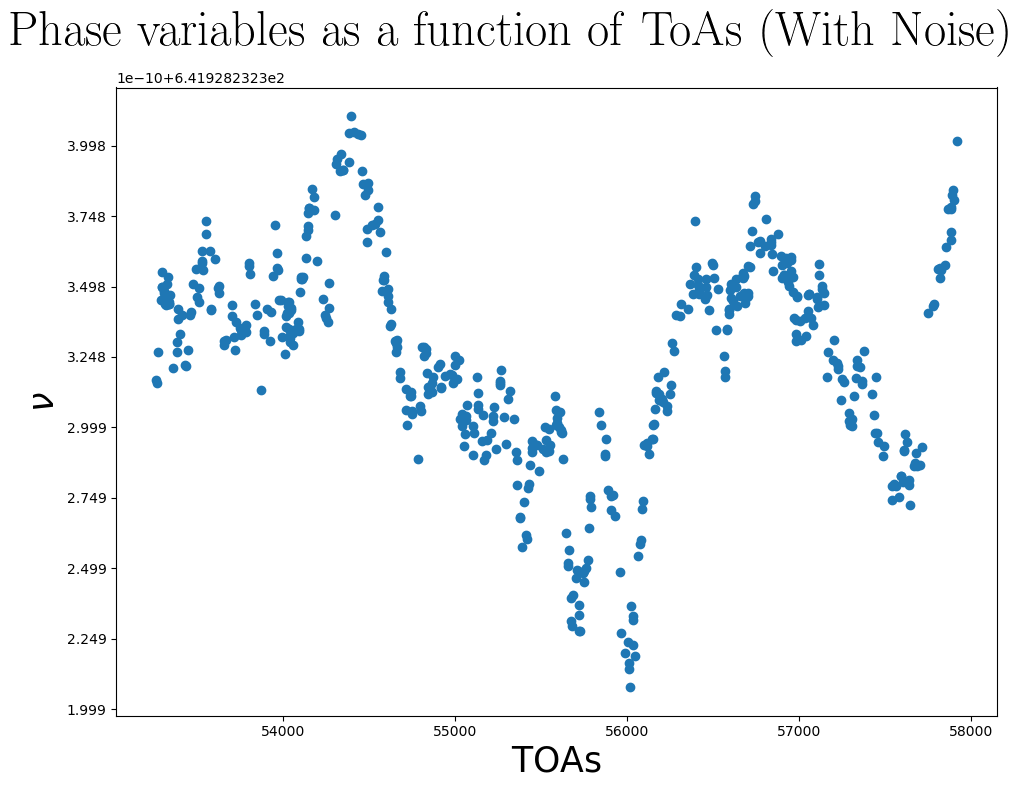

Getting the real residuals
[tempo2Util.C:396] Warning: [MISC1] Unknown parameter in par file:  DMX
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.

[tempo2Util.C:396] Warning: [PAR2] Have not set a DM epoch. The period epoch will be used instead. data/par/B1937+21_NANOGrav_12yv4.wb.gls.par
[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
Generating fake residuals
[tempo2Util.C:396] Warning: [PAR1] Have not set a position epoch. The period epoch will be used instead. data/fake_residuals/B1937+21.par
Generating final plot


/var/folders/bx/dsrq957n43bckqdm1vkk78yc0000gn/T/ipykernel_94481/1746056384.py:61: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PSR_REAL = libstempo.tempopulsar(parfile=f"{data_path}par/{psr_name}_NANOGrav_12yv4.wb.gls.par", timfile=f"{data_path}tim/{psr_name}_NANOGrav_12yv4.wb.tim")
/var/folders/bx/dsrq957n43bckqdm1vkk78yc0000gn/T/ipykernel_94481/1365724514.py:65: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr_TG=libstempo.tempopulsar(parfile=par_nN,


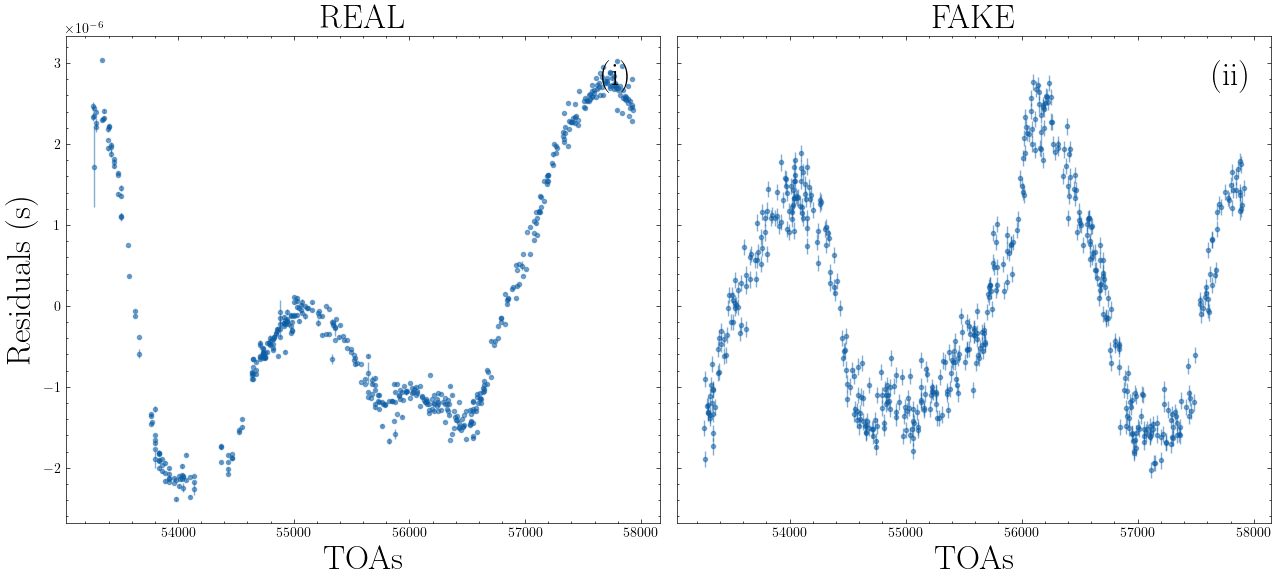

In [4]:
pulsar_pipeline("B1937+21",error_on_toa=1e-7,sigma_2=1e-28)

# Residual Comparison